In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install lightning
!pip install pytorch_forecasting

In [ ]:
import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger
import numpy as np
import pandas as pd
import torch

import optuna
from optuna.integration import PyTorchLightningPruningCallback


from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer, TorchNormalizer, MultiNormalizer,EncoderNormalizer
from pytorch_forecasting.metrics import MAE, SMAPE, PoissonLoss, QuantileLoss, MAPE, MultivariateNormalDistributionLoss,MultiHorizonMetric

import pandas as pd
import numpy as np


#from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters


# Creating Multi Step Dataset

In [ ]:
df    = pd.read_csv("/content/drive/MyDrive/BDA696Project/Datasets/processsed/YMH_Clean_UCI_Power_Consumption_Dataset.csv")
cpi   = pd.read_csv("/content/drive/MyDrive/BDA696Project/Datasets/processsed/YM_Clean_France_CPI_Electricity.csv")
temp  = pd.read_csv("/content/drive/MyDrive/BDA696Project/Datasets/processsed/YMH_Clean_TempISD.csv")
cci   = pd.read_csv("/content/drive/MyDrive/BDA696Project/Datasets/processsed/YM_Clean_CCI.csv")
gt1   = pd.read_csv("/content/drive/MyDrive/BDA696Project/Datasets/processsed/YMW_Clean_GoogleTrends1.csv")
gt2   = pd.read_csv("/content/drive/MyDrive/BDA696Project/Datasets/processsed/YMW_Clean_GoogleTrends2.csv")
gt3   = pd.read_csv("/content/drive/MyDrive/BDA696Project/Datasets/processsed/YMW_Clean_GoogleTrends3.csv")


<ipython-input-33-968a71a3a344>:1: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df    = pd.read_csv("/content/drive/MyDrive/BDA696Project/Datasets/processsed/YMH_Clean_UCI_Power_Consumption_Dataset.csv")
<ipython-input-33-968a71a3a344>:3: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  temp  = pd.read_csv("/content/drive/MyDrive/BDA696Project/Datasets/processsed/YMH_Clean_TempISD.csv")


In [ ]:
ISD = pd.read_csv('/content/drive/MyDrive/BDA696Project/TFT_Model_Datasets/ISD_cleaned.csv')
ISD['Date'] = pd.to_datetime(ISD['New_Date'])
ISD=ISD[['Date','Wind_Speed_Norm','Prec_Depth_Norm','Air_Temp_Norm']]
# ISD = ISD.drop_duplicates(subset='New_Date', keep='first')
# ISD.sort_values(by='New_Date', ascending = False)
# Wind_Speed_Agg = ISD.resample('D', on='New_Date').Wind_Speed_Norm.mean()
# Prec_Depth_Agg = ISD.resample('D', on='New_Date').Prec_Depth_Norm.mean()
# Air_Temp_Agg = ISD.resample('D', on='New_Date').Air_Temp_Norm.mean()

<ipython-input-34-a0624b3daacb>:1: DtypeWarning: Columns (27) have mixed types. Specify dtype option on import or set low_memory=False.
  ISD = pd.read_csv('/content/drive/MyDrive/BDA696Project/TFT_Model_Datasets/ISD_cleaned.csv')


In [ ]:
# df    = pd.read_csv("Downloads/processsed/YMH_Clean_UCI_Power_Consumption_Dataset.csv")
# cpi   = pd.read_csv("Downloads/processsed/YM_Clean_France_CPI_Electricity.csv")
# temp  = pd.read_csv("Downloads/processsed/YMH_Clean_TempISD.csv")
# cci   = pd.read_csv("Downloads/processsed/YM_Clean_CCI.csv")
# gt1   = pd.read_csv("Downloads/processsed/YMW_Clean_GoogleTrends1.csv")
# gt2   = pd.read_csv("Downloads/processsed/YMW_Clean_GoogleTrends2.csv")
# gt3   = pd.read_csv("Downloads/processsed/YMW_Clean_GoogleTrends3.csv")


In [ ]:
df['Date'] = pd.to_datetime(df['Date'])
df=df.query('(Date.dt.hour==0 or Date.dt.hour==6 or Date.dt.hour==12 or Date.dt.hour==18) and Date.dt.minute==0')# or Date.dt.minute==30')
df=df.replace('?',0.0)
df.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,2007-01-01 00:00:00,00:00:00,2.580,0.136,241.970,10.600,0.000,0.000,0.0
360,2007-01-01 06:00:00,06:00:00,2.460,0.064,241.130,10.200,0.000,0.000,0.0
720,2007-01-01 12:00:00,12:00:00,2.478,0.000,235.300,10.400,0.000,0.000,0.0
1080,2007-01-01 18:00:00,18:00:00,1.416,0.000,239.130,5.800,0.000,0.000,17.0
1440,2007-01-02 00:00:00,00:00:00,0.442,0.122,241.060,1.800,0.000,0.000,0.0


## Creating and using function to foward fill weekly and monthly values

In [ ]:
def fillblanks(df_temp):
  temp = pd.DataFrame(pd.date_range(start=df_temp['Date'].min(), end= df_temp['Date'].max()),columns=['Date'])
  temp['Date'] = pd.to_datetime(temp['Date'])
  temp = temp.merge(df_temp, on='Date', how='left')
  temp = temp.replace(0, np.nan).ffill()
  return temp

In [ ]:
#temp['Date'] = pd.to_datetime(cci['Date'])
#df=pd.merge_asof(df,temp, on='Date')

#df.dtypes

cpi['Date'] = pd.to_datetime(cpi['Date'])
df=df.merge(fillblanks(cpi), on='Date', how='left')
df['CPI'] = df['CPI'].replace(0, np.nan).ffill()

cci['Date'] = pd.to_datetime(cci['Date'])
df=df.merge(fillblanks(cci), on='Date', how='left')
df['CCI'] = df['CCI'].replace(0, np.nan).ffill()

ISD['Date'] = pd.to_datetime(ISD['Date'])
df=df.merge(fillblanks(ISD), on='Date', how='left')
df['Wind_Speed_Norm'] = df['Wind_Speed_Norm'].replace(0, np.nan).ffill()
df['Prec_Depth_Norm'] = df['Prec_Depth_Norm'].replace(0, np.nan).ffill()
df['Air_Temp_Norm'] = df['Air_Temp_Norm'].replace(0, np.nan).ffill()


gt1['Date'] = pd.to_datetime(gt1['Date'])
df=df.merge(fillblanks(gt1), on='Date', how='left')
df['GT1_Hits'] = df['GT1_Hits'].replace(0, np.nan).ffill()


gt2['Date'] = pd.to_datetime(gt2['Date'])
df=df.merge(fillblanks(gt2), on='Date', how='left')
df['GT2_Hits'] = df['GT2_Hits'].replace(0, np.nan).ffill()


gt3['Date'] = pd.to_datetime(gt3['Date'])
df=df.merge(fillblanks(gt3), on='Date', how='left')
df['GT3_Hits'] = df['GT3_Hits'].replace(0, np.nan).ffill()



In [ ]:
df=df.fillna(value=0)

In [ ]:
earliest_time= df['Date'].min()

In [ ]:
df["day_of_week"] = df['Date'].dt.dayofweek.astype(str) # categories have be strings
df["week_of_year"] = df['Date'].dt.isocalendar().week.astype(str)  # categories have be strings
df["month"] = df['Date'].dt.month.astype(str)
df['hour'] = df['Date'].dt.hour.astype(str)
df['day'] = df['Date'].dt.day.astype(str)
df['year'] = df['Date'].dt.year-2006
df['year']=df['year'].astype('int')
#df['minute'] = df['Date'].dt.minute.astype(str).astype("int")
df['time_idx']=df.index
df['hours_from_start'] = (df['Date'] - earliest_time).dt.seconds / 60 / 60 + (df['Date'] - earliest_time).dt.days * 24
df['hours_from_start'] = df['hours_from_start'].astype('int')
df['days_from_start'] = (df['Date'] - earliest_time).dt.days
df['group']=0
df['Global_active_power']=df['Global_active_power'].astype("float64")
df['Voltage']=df['Voltage'].astype("float64")
df['Global_intensity']=df['Global_intensity'].astype("float64")
df['Sub_metering_1']=df['Sub_metering_1'].astype("float64")
df['Sub_metering_2']=df['Sub_metering_2'].astype("float64")
df['Wind_Speed_Norm'] = df['Wind_Speed_Norm'].astype("float64")
df['Prec_Depth_Norm'] = df['Prec_Depth_Norm'].astype("float64")
df['Air_Temp_Norm'] = df['Air_Temp_Norm'].astype("float64")


time_df = df[[
    'Global_active_power'
    ,'Sub_metering_1'
    ,'Sub_metering_2'
    ,'Sub_metering_3'
,'CPI'
,'CCI'
,'GT1_Hits'
,'GT2_Hits'
,'GT3_Hits'
,'Wind_Speed_Norm'
,'Prec_Depth_Norm'
,'Air_Temp_Norm'
,'day_of_week'
,'week_of_year'
,'year'
,'month'
,'hour'
,'day'
,'time_idx'
,'days_from_start'
,'group'
,'Date'
]]
df.dtypes

Date                     datetime64[ns]
Time                             object
Global_active_power             float64
Global_reactive_power            object
Voltage                         float64
Global_intensity                float64
Sub_metering_1                  float64
Sub_metering_2                  float64
Sub_metering_3                  float64
CPI                             float64
CCI                             float64
Wind_Speed_Norm                 float64
Prec_Depth_Norm                 float64
Air_Temp_Norm                   float64
GT1_Hits                        float64
GT2_Hits                        float64
GT3_Hits                        float64
day_of_week                      object
week_of_year                     object
month                            object
hour                             object
day                              object
year                              int64
time_idx                          int64
hours_from_start                  int64


In [ ]:
time_df.isna().values.sum()


0

In [ ]:
time_df.head()

,Global_active_power,Sub_metering_1,Sub_metering_2,Sub_metering_3,CPI,CCI,GT1_Hits,GT2_Hits,GT3_Hits,Wind_Speed_Norm,...,day_of_week,week_of_year,year,month,hour,day,time_idx,days_from_start,group,Date
0,2.580,0.0,0.0,0.0,72.71,100.0,45.0,41.0,0.0,1.583333,...,0,1,1,1,0,1,0,0,0,2007-01-01 00:00:00
1,2.460,0.0,0.0,0.0,72.71,100.0,45.0,41.0,0.0,1.583333,...,0,1,1,1,6,1,1,0,0,2007-01-01 06:00:00
2,2.478,0.0,0.0,0.0,72.71,100.0,45.0,41.0,0.0,1.583333,...,0,1,1,1,12,1,2,0,0,2007-01-01 12:00:00
3,1.416,0.0,0.0,17.0,72.71,100.0,45.0,41.0,0.0,1.583333,...,0,1,1,1,18,1,3,0,0,2007-01-01 18:00:00
4,0.442,0.0,0.0,0.0,72.71,100.0,45.0,41.0,0.0,1.277778,...,1,1,1,1,0,2,4,1,0,2007-01-02 00:00:00


# Setting up Time Series DataLoaders



In [ ]:
#Hyperparameters
#batch size=64
#number heads=4, hidden sizes=160, lr=0.001, gr_clip=0.1

max_prediction_length = 4*7*4*6 #sixmonths
max_encoder_length = 4*365 #one year
training_cutoff = time_df["time_idx"].max() - max_prediction_length

training = TimeSeriesDataSet(
    time_df[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="Global_active_power",
    group_ids=['group'],
    min_encoder_length=4*7, #one week
    max_encoder_length=max_encoder_length,
    min_prediction_length=4, #one day
    max_prediction_length=max_prediction_length,
    #static_categoricals=["consumer_id"],
    time_varying_known_categoricals=["day","day_of_week", "month", 'hour' ], #year to be added
    time_varying_known_reals=["time_idx",'year'],
    time_varying_unknown_reals=['Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3','CPI','CCI','GT1_Hits','GT2_Hits','GT3_Hits','Wind_Speed_Norm','Prec_Depth_Norm','Air_Temp_Norm'], #temp to be added
    target_normalizer=GroupNormalizer(
          groups=["group"], transformation="softplus"
      ),  # we normalize by group
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
    #add_nan=True,
    allow_missing_timesteps=True
)


validation = TimeSeriesDataSet.from_dataset(training, time_df, predict=True, stop_randomization=True)

# create dataloaders for  our model
batch_size = 64
# if you have a strong GPU, feel free to increase the number of workers
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=10)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=10)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[I 2023-12-10 07:14:28,911] Trial 3 finished with value: 0.31155362725257874 and parameters: {'gradient_clip_val': 0.8223697202530604, 'hidden_size': 22, 'dropout': 0.2972505585187706, 'hidden_continuous_size': 9, 'attention_head_size': 1, 'learning_rate': 0.014035308702029799}. Best is trial 2 with value: 0.29049456119537354.


#Saving the Model

In [ ]:
#!unzip /content/drive/MyDrive/BDA696Project/Model/model.zip
#torch.save(best_tft.state_dict(), path)


In [ ]:
best_model_path='/content/drive/MyDrive/BDA696Project/Model/model_saved/lightning_logs/lightning_logs/version_0/checkpoints/epoch=7-step=880.ckpt'
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:198: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:198: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


In [ ]:
#Take a look at what the raw_predictions variable contains

raw_predictions = best_tft.predict(val_dataloader, mode="raw", return_x=True)
print(raw_predictions._fields)
#('output', 'x', 'index', 'decoder_lengths', 'y')

print('\n')
#print(raw_predictions.output._fields)
# ('prediction',
# 'encoder_attention',
# 'decoder_attention',
# 'static_variables',
# 'encoder_variables',
# 'decoder_variables',
# 'decoder_lengths',
# 'encoder_lengths')

print('\n')
#print(raw_predictions.output.prediction.shape)
#torch.Size([5, 24, 7])

# We get predictions of 5 time-series for 24 days.
# For each day we get 7 predictions - these are the 7 quantiles:
#[0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98]
# We are mostly interested in the 4th quantile which represents, let's say, the 'median loss'
# fyi, although docs use the term quantiles, the most accurate term are percentiles

# We get predictions of 5 time-series for 24 days.
# For each day we get 7 predictions - these are the 7 quantiles:
#[0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98]
# We are mostly interested in the 4th quantile which represents, let's say, the 'median loss'
# fyi, although docs use the term quantiles, the most accurate term are percentiles

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, low

('output', 'x', 'index', 'decoder_lengths', 'y')






#Loss Comparision: TFT VS Baseline




## Using 'prediction' mode for calculating loss function

In [ ]:
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = best_tft.predict(val_dataloader, mode="prediction").to('cpu')
baseline_predictions = Baseline().predict(val_dataloader).to('cpu')

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, usin

##MAE

In [ ]:
mae_loss = MAE()
print(f"TFT: {mae_loss.loss(actuals, predictions).mean(axis = 1).median().item()}")
print(f"Baseline: {mae_loss.loss(actuals, baseline_predictions).mean(axis = 1).median().item()}")

TFT: 0.549065113067627
Baseline: 0.5105714201927185


##SMAPE


In [ ]:
sm = SMAPE()
print(f"TFT: {sm.loss(actuals, predictions).mean(axis = 1).median().item()}")
print(f"Baseline: {sm.loss(actuals, baseline_predictions).mean(axis = 1).median().item()}")

TFT: 0.6751478910446167
Baseline: 0.729117214679718


##MAPE

In [ ]:
mape = MAPE()
print(f"TFT: {mape.loss(actuals, predictions).mean(axis = 1).median().item()}")
print(f"Baseline: {mape.loss(actuals, baseline_predictions).mean(axis = 1).median().item()}")

TFT: 0.9968411326408386
Baseline: 1.7605912685394287


##Poisson Loss

In [ ]:
pl = PoissonLoss()
print(f"TFT: {pl.loss(actuals, predictions).mean(axis = 1).median().item()}")
print(f"Baseline: {pl.loss(actuals, baseline_predictions).mean(axis = 1).median().item()}")

TFT: 3.1876018047332764
Baseline: 3.5891759395599365


##Quantile Loss

In [ ]:
ql = QuantileLoss()
print(f"TFT: {ql.loss(actuals.view(1, -1),predictions.view(1, -1)).mean().item()}")
print(f"Baseline: {ql.loss(actuals.view(1, -1),baseline_predictions.view(1, -1)).mean().item()}")

TFT: 0.9532883763313293
Baseline: 1.0016515254974365


#Observed vs Predicted

## Using 'raw' mode

<ipython-input-54-86e257ce8775>:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-deep')


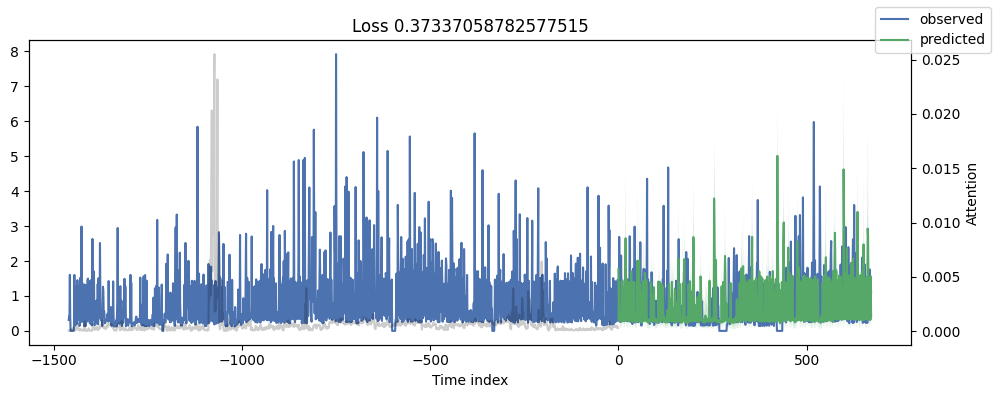

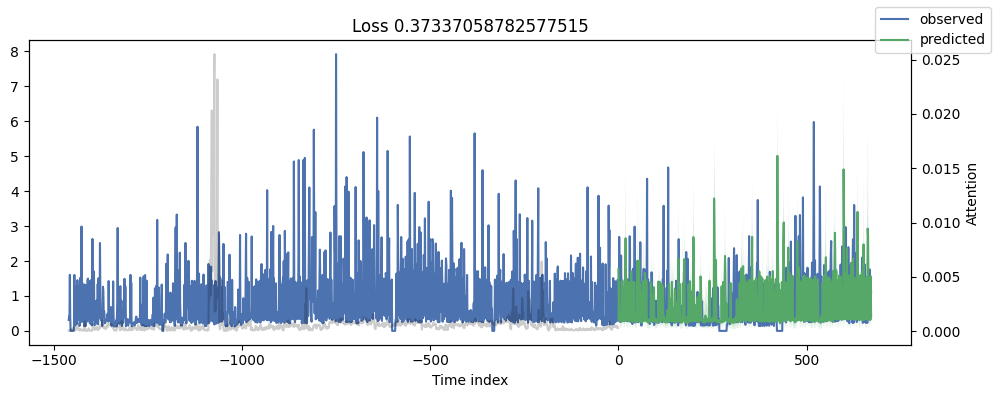

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-deep')
fig, ax = plt.subplots(figsize=(10, 4))
best_tft.plot_prediction(raw_predictions.x, raw_predictions.output, idx=0, add_loss_to_title=True,ax=ax)

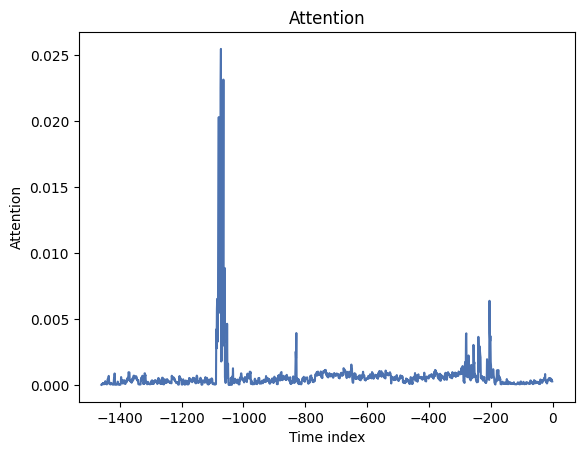

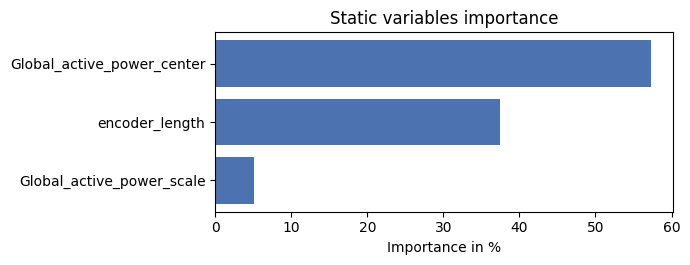

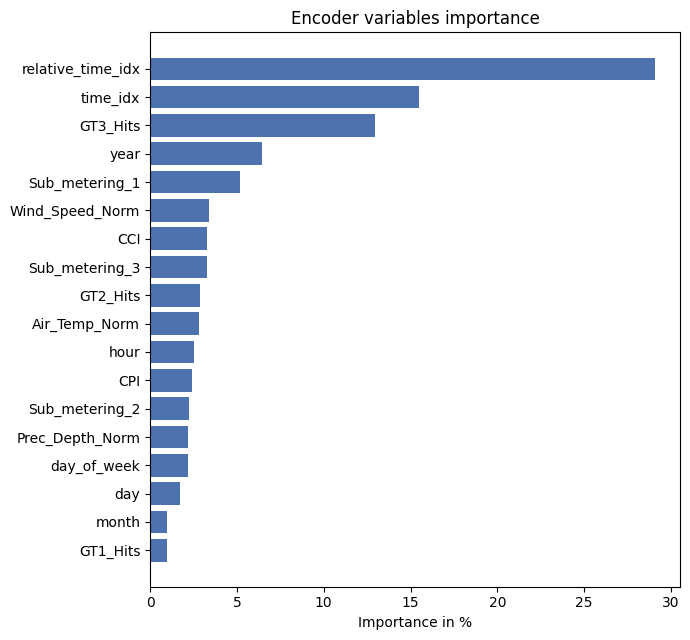

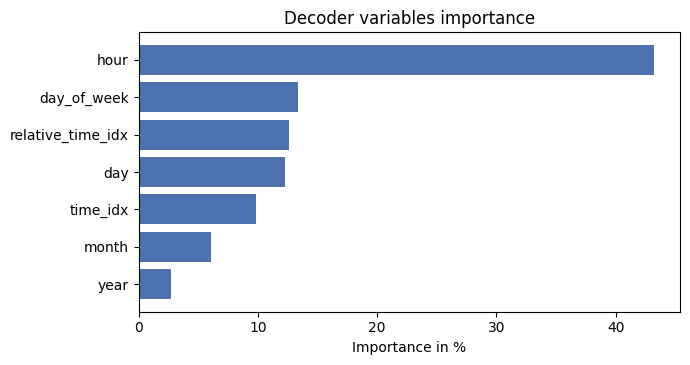

In [ ]:
interpretation = best_tft.interpret_output(raw_predictions.output, reduction="sum")
#interpretation
plt.show(best_tft.plot_interpretation(interpretation))


## Using 'prediction' mode

In [ ]:
predictions=best_tft.predict(val_dataloader,mode='prediction',return_x=True)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, low

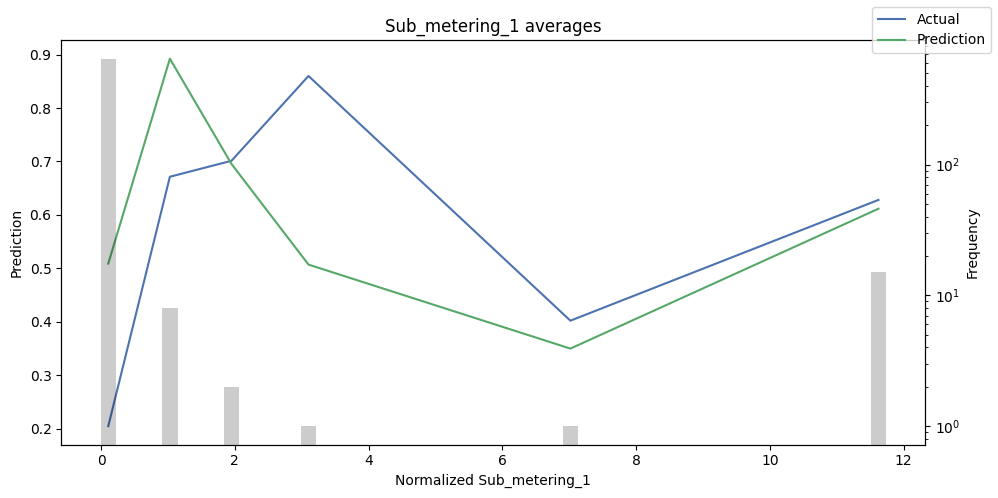

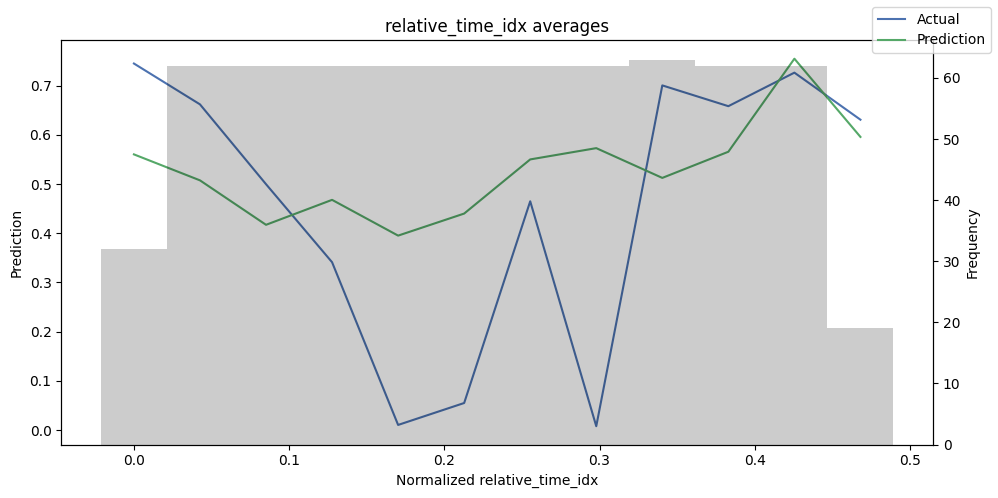

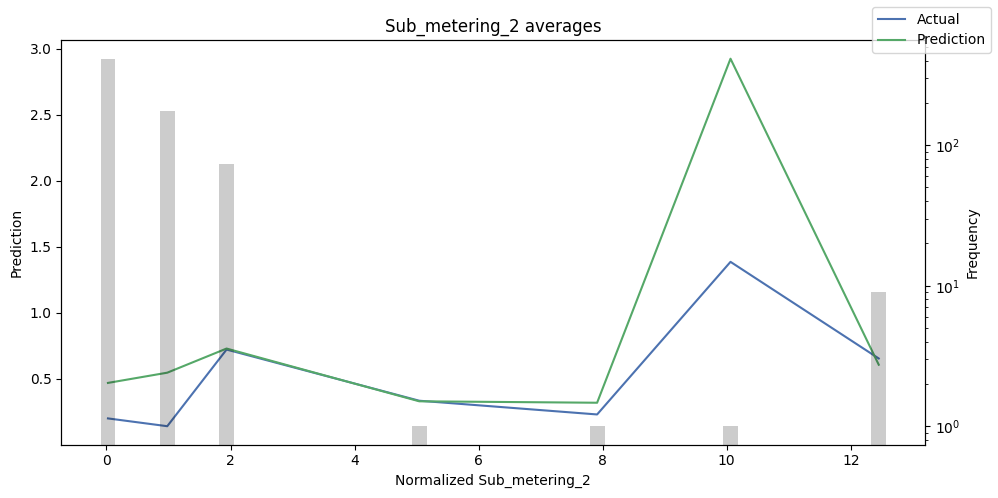

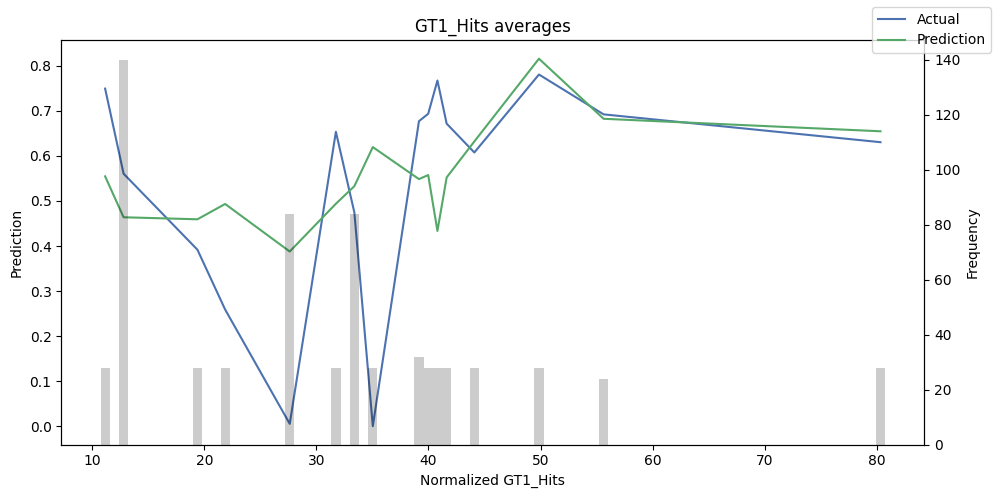

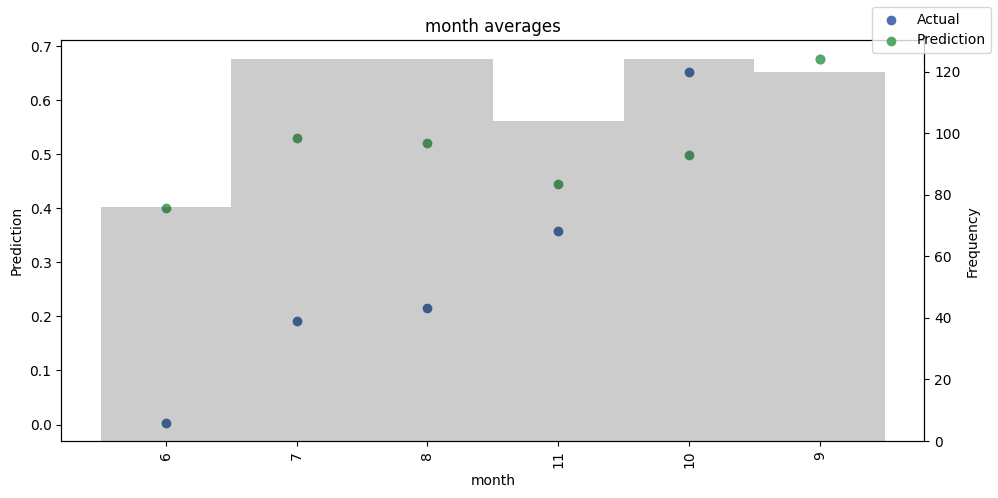

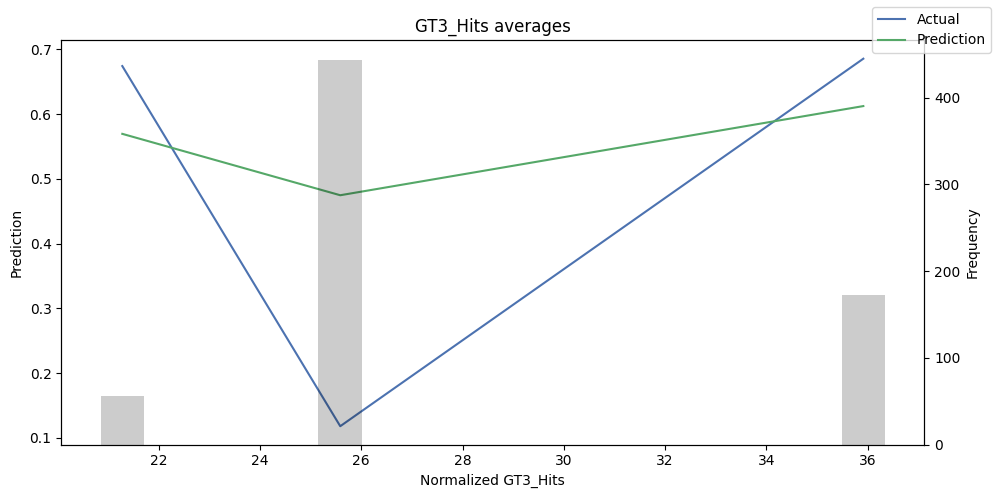

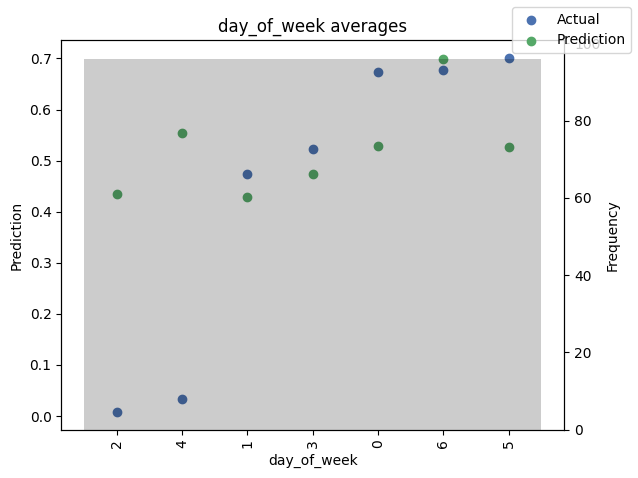

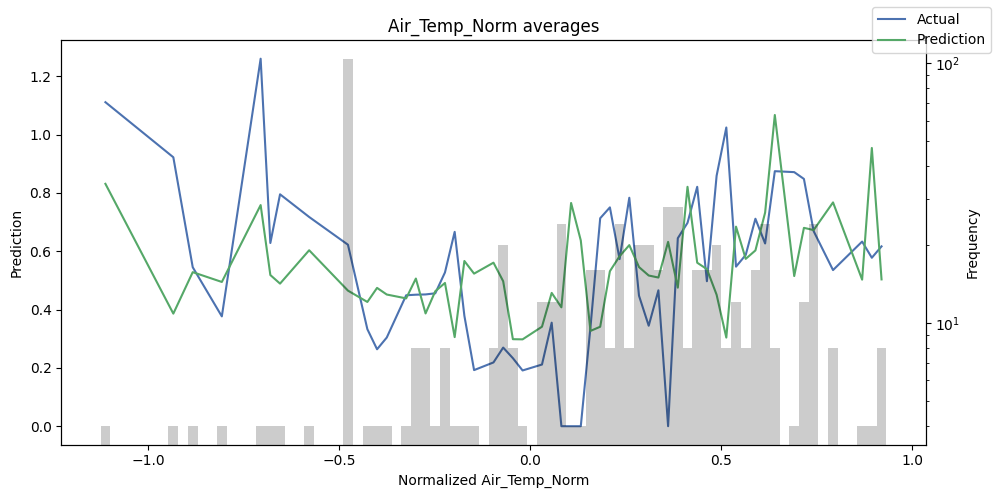

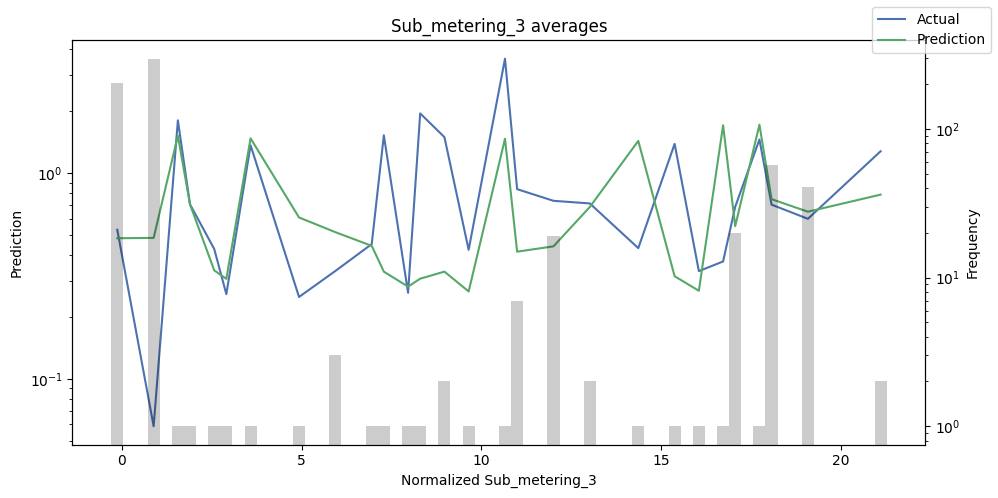

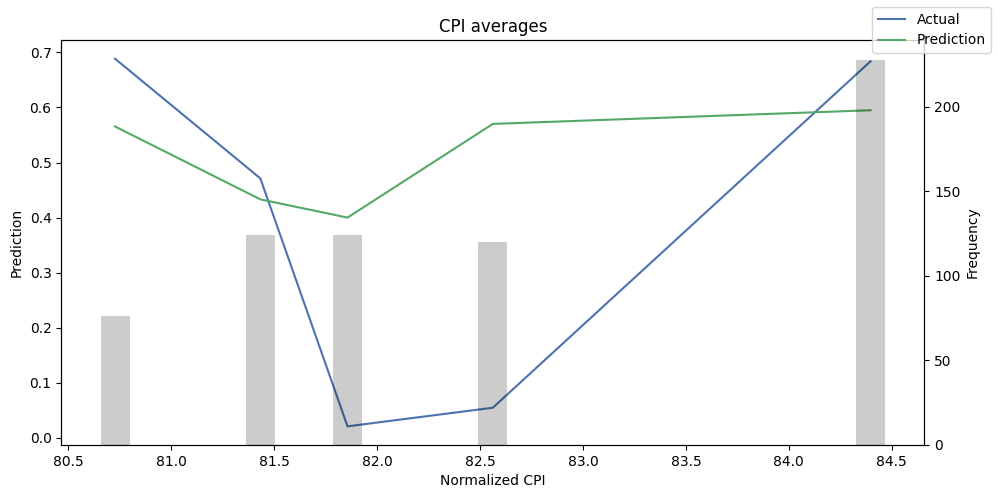

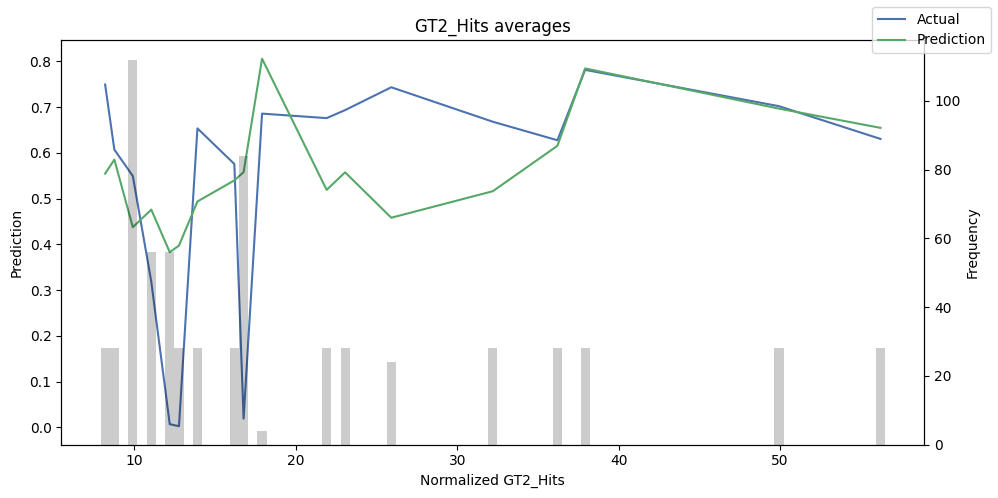

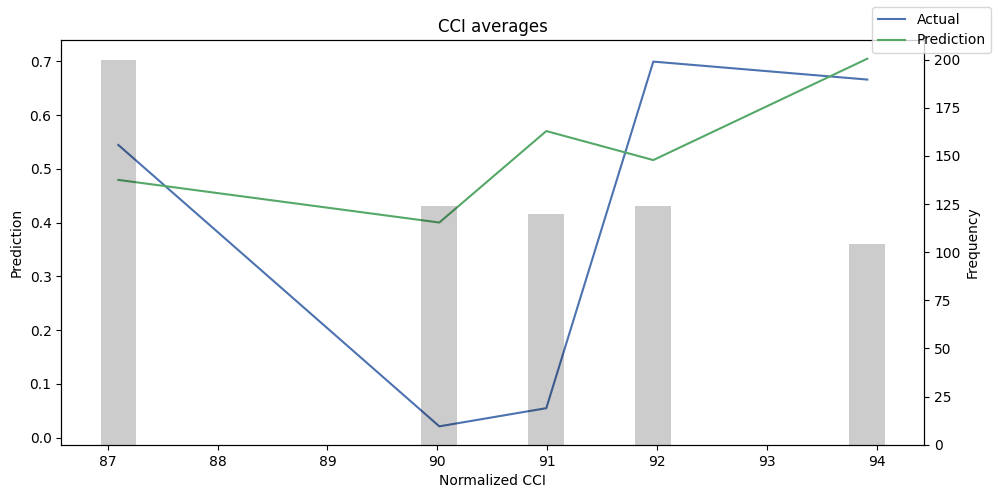

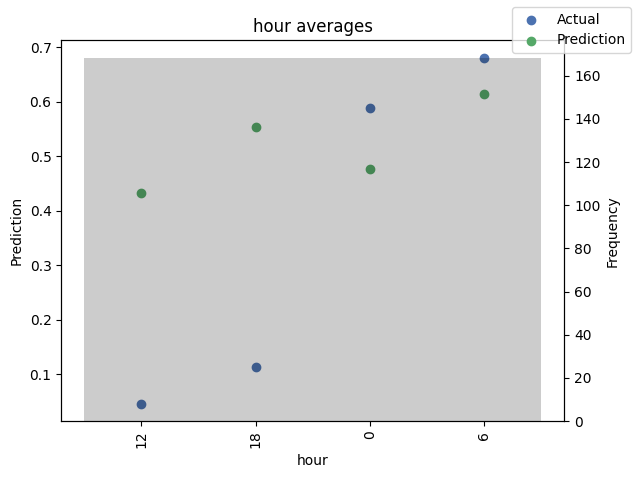

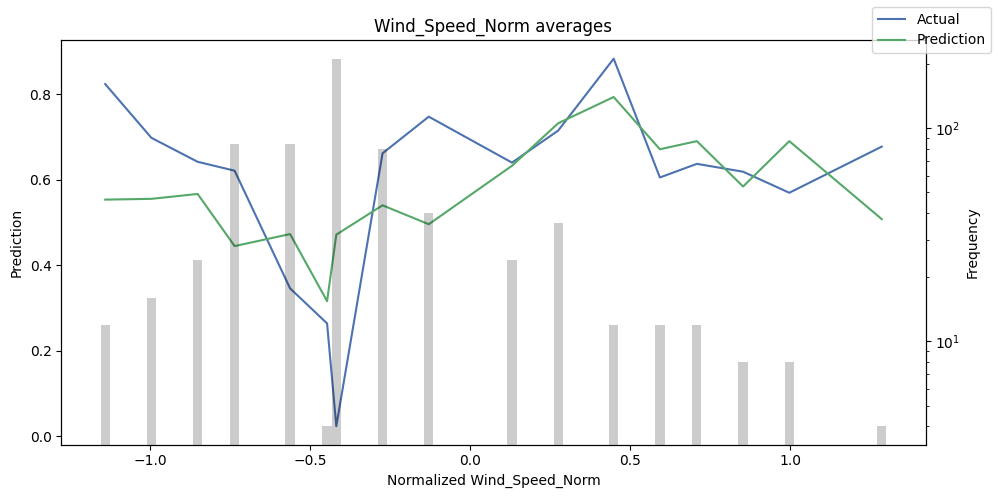

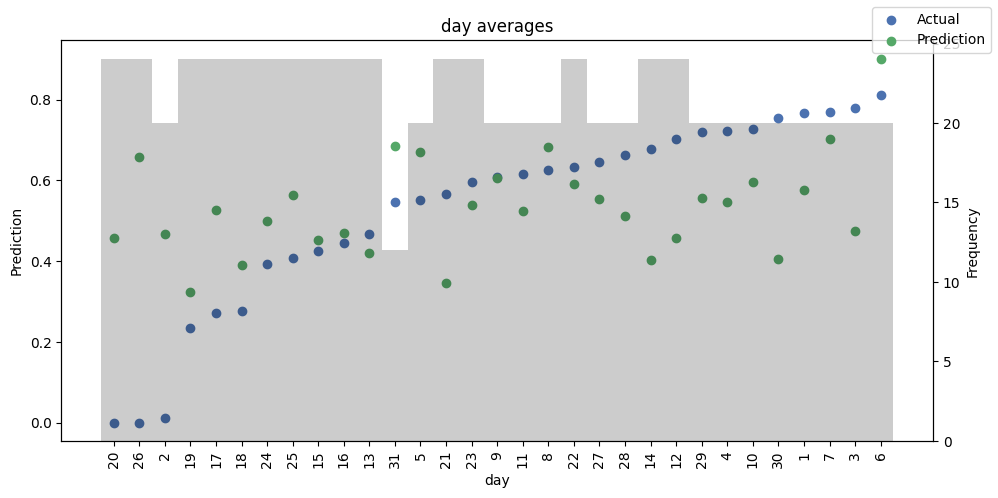

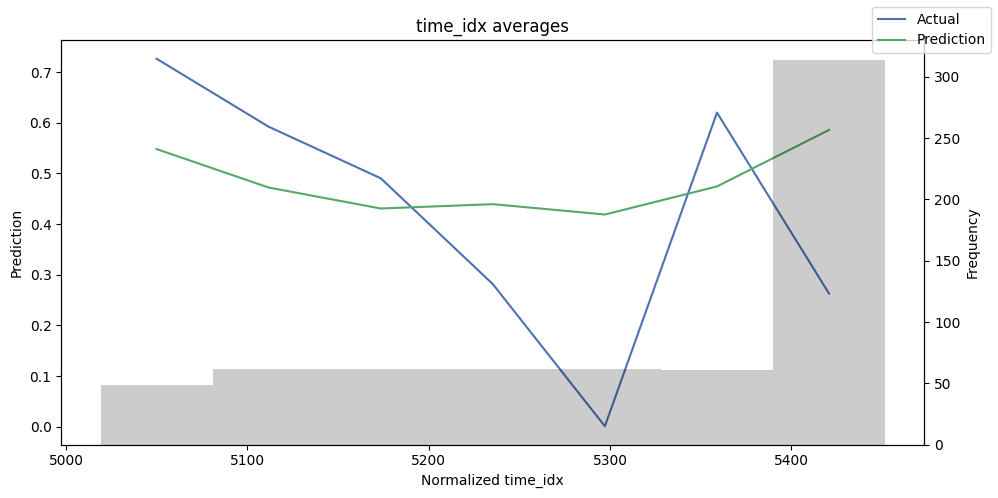

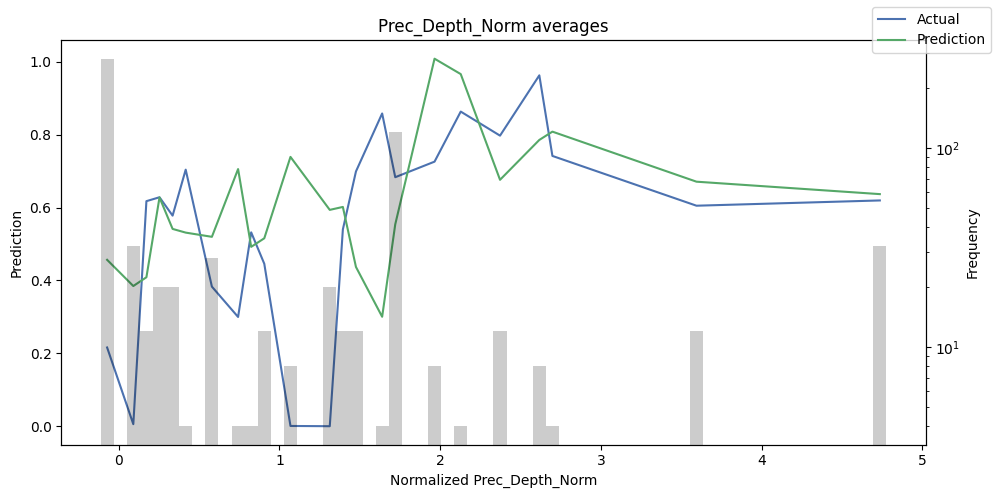

In [ ]:
predictions_vs_actuals = best_tft.calculate_prediction_actual_by_variable(predictions.x, predictions.output)
all_features = list(set(predictions_vs_actuals['support'].keys())-set(['year', 'encoder_length', 'Global_active_power_scale','Global_active_power_center']))
for feature in all_features:
    best_tft.plot_prediction_actual_by_variable(predictions_vs_actuals, name=feature);

Predict:   0%|          | 0/30 [00:00<?, ? batches/s]

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider incr

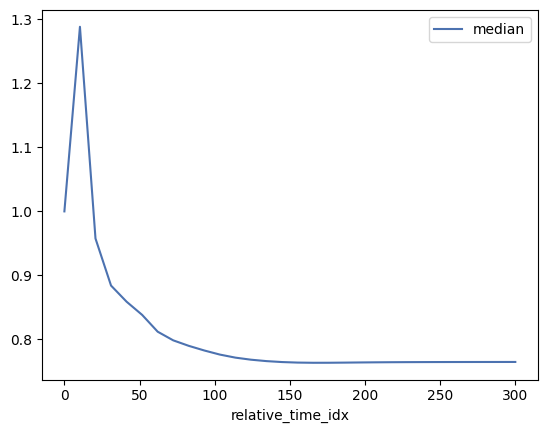

In [ ]:
dependency = best_tft.predict_dependency(val_dataloader.dataset, 'relative_time_idx', np.linspace(0, 300, 30), show_progress_bar=True, mode="dataframe")
# plotting median and 25% and 75% percentile
agg_dependency = dependency.groupby('relative_time_idx').normalized_prediction.agg(median="median", q25=lambda x: x.quantile(0.25), q75=lambda x: x.quantile(0.75))
ax = agg_dependency.plot(y="median")
ax.fill_between(agg_dependency.index, agg_dependency.q25, agg_dependency.q75, alpha=0.01)